### 1) Gathering Input Graphs

In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [5]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-productivity-rate-graphs"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

In [6]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [7]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 2) GAT Global Attention Model fro XAI


=== Fold 1 ===
Epoch 1/10 - Train Loss: 1.0978
Epoch 2/10 - Train Loss: 1.0344
Epoch 3/10 - Train Loss: 0.6772
Epoch 4/10 - Train Loss: 0.4603
Epoch 5/10 - Train Loss: 0.2330
Epoch 6/10 - Train Loss: 0.1420
Epoch 7/10 - Train Loss: 0.0883
Epoch 8/10 - Train Loss: 0.0882
Epoch 9/10 - Train Loss: 0.0757
Epoch 10/10 - Train Loss: 0.0546
Baseline RMSE: 0.5571
Permuted contact duration: RMSE = 0.5754 | Importance = 0.0183
Permuted timestamp: RMSE = 0.5730 | Importance = 0.0159
Permuted antenna ID: RMSE = 0.5558 | Importance = -0.0013

=== Fold 2 ===
Epoch 1/10 - Train Loss: 0.8773
Epoch 2/10 - Train Loss: 0.7947
Epoch 3/10 - Train Loss: 0.3912
Epoch 4/10 - Train Loss: 0.2546
Epoch 5/10 - Train Loss: 0.1529
Epoch 6/10 - Train Loss: 0.1424
Epoch 7/10 - Train Loss: 0.1071
Epoch 8/10 - Train Loss: 0.1379
Epoch 9/10 - Train Loss: 0.0968
Epoch 10/10 - Train Loss: 0.0732
Baseline RMSE: 0.7831
Permuted contact duration: RMSE = 0.7981 | Importance = 0.0150
Permuted timestamp: RMSE = 0.8075 | Import

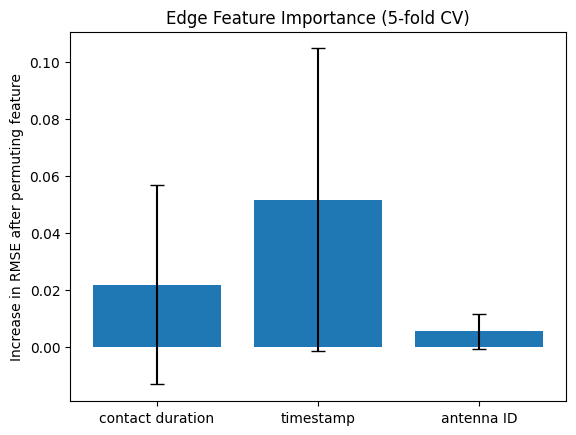

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import AttentionalAggregation
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATv2Conv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.att_pool = AttentionalAggregation(gate_nn=torch.nn.Sequential(torch.nn.Linear(hidden_dim, 1)))
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_model(train_graphs, in_node_feats, in_edge_feats, epochs=50, batch_size=1, lr=0.001):
    model = GATGraphRegressor(in_node_feats, in_edge_feats).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, num_workers=0)

    model.train()
    for epoch in range(epochs):
        epoch_losses = []
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_loss:.4f}")
    return model

def evaluate_rmse(model, graphs, batch_size=1):
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(all_targets, all_preds, squared=False)
    return rmse

def permute_feature_and_evaluate(model, graphs, feature_idx, batch_size=1):
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            edge_attr = batch.edge_attr.clone()
            permuted_feature = edge_attr[:, feature_idx][torch.randperm(edge_attr.size(0))]
            edge_attr[:, feature_idx] = permuted_feature
            batch.edge_attr = edge_attr
            out = model(batch)
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(all_targets, all_preds, squared=False)
    return rmse

feature_names = ["contact duration", "timestamp", "antenna ID"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

importances = {name: [] for name in feature_names}

in_node_feats = max_node_dim
in_edge_feats = max_edge_dim

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"\n=== Fold {fold + 1} ===")
    train_subset = [graphs_padded[i] for i in train_idx]
    val_subset = [graphs_padded[i] for i in val_idx]

    model = train_model(train_subset, in_node_feats, in_edge_feats, epochs=10)  # you can increase epochs later

    baseline_rmse = evaluate_rmse(model, val_subset)
    print(f"Baseline RMSE: {baseline_rmse:.4f}")

    for i, fname in enumerate(feature_names):
        permuted_rmse = permute_feature_and_evaluate(model, val_subset, i)
        importance = permuted_rmse - baseline_rmse
        importances[fname].append(importance)
        print(f"Permuted {fname}: RMSE = {permuted_rmse:.4f} | Importance = {importance:.4f}")

means = [np.mean(importances[name]) for name in feature_names]
stds = [np.std(importances[name]) for name in feature_names]

plt.bar(feature_names, means, yerr=stds, capsize=5)
plt.ylabel("Increase in RMSE after permuting feature")
plt.title("Edge Feature Importance (5-fold CV)")
plt.show()


### 3) Edge Feature Importance from Permutation (Graph Results)

- **Contact duration:** Increase in RMSE ≈ 0.02  
- **Timestamp:** Increase in RMSE ≈ 0.06  
- **Antenna ID:** Increase in RMSE ≈ 0.01  

---

#### What does this mean?

Permuting (shuffling) each edge feature randomly tests how important that feature is to the model. The small increases in RMSE mean:

- **Timestamp** has the highest importance but still very low (0.06 increase)  
- **Contact duration** and **antenna ID** have very minor importance (0.02 and 0.01)  

---

#### Main takeaway:

The model barely depends on the edge attributes to make predictions. It mostly uses the graph’s node features and connectivity structure, not the detailed edge information.
